# TAL - Classement de citations Chirac / Miterrand

Dans ce notebook, nous travaillons sur un corpus de citations de Chirac et Mitterrand. Notre but est de construire un modèle entraîné sur ces données, capable de prédire si une citation a été prononcée par Chirac ou Mitterrand.

# Chargement des données

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import codecs

In [4]:
# librairies utiles à la manipulation de données textuelles

import string
from unidecode import unidecode
import re


# Fonction de "nettoyage" basique, supprimant les majuscule, la ponctuation, les chiffres et les accents
def preprocess(txt) :
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    txt = txt.translate(translator)
    txt = unidecode(txt)
    txt = txt.lower()
    txt = re.sub(r'[0-9]+', '', txt)
    return txt


# Fonction de chargement des donnees avec les étiquettes associées
# avec l'application des "nettoyages" precedents
# Renvoie une liste contenant les textes (citations) pré-traitées, et une liste des étiquettes associées
# (1 pour Chirac et -1 pour Mitterrand)

def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        #print(txt, lab)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        #print(txt)
        txt = preprocess(txt)
        #print(txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

In [6]:
# Chargement des données

fname = "ressources/AFDpresidentutf8/corpus.tache1.learn.utf8"

alltxts,alllabs = load_pres(fname)

In [5]:
print(alltxts[12], ':', alllabs[12])
print(alltxts[1], ':', alllabs[1])

 c est vrai qu il y a tres souvent dans notre pays un refus de regarder droit devant soi  comme un souhait d en rester la  une certaine peur du changement  c est vrai 
 : -1
 d abord merci de cet exceptionnel accueil que les congolais  les brazavillois  nous ont reserve cet apres midi 
 : 1


On souhaite connaître les proportion de citations de Mitterrand et de Chirac.

In [7]:
nb_citations_chirac = alllabs.count(1)
nb_citations_mitterrand = alllabs.count(-1)

print('Chirac :', nb_citations_chirac, 'citations (', nb_citations_chirac/len(alllabs), '% du corpus )')
print('\n')
print('Mitterrand :', nb_citations_mitterrand, 'citations (', nb_citations_mitterrand/len(alllabs), '% du corpus )')

Chirac : 49890 citations ( 0.8689669587027329 % du corpus )


Mitterrand : 7523 citations ( 0.13103304129726717 % du corpus )


La répartition des données est assez déséquilibrée, nous verrons si cela impacte nos modèles.

## Approche sacs de mots

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(alltxts)
print(vectorizer.get_feature_names_out()[:10]) # we only print a few
dic_size = len(vectorizer.get_feature_names_out())
print('Taille du dictionnaire :',dic_size)

['aaron' 'ab' 'abaissaient' 'abaissant' 'abaisse' 'abaissement'
 'abaissent' 'abaisser' 'abandon' 'abandonne']
Taille du dictionnaire : 27054


In [12]:
X

<57413x27054 sparse matrix of type '<class 'numpy.int64'>'
	with 1055941 stored elements in Compressed Sparse Row format>

Nous souhaitons savoir quels mots sont les plus fréquents avec cette approche, sans pré-traitement.

['', 'de', '\n', 'la', 'et', 'l', 'a', 'le', 'les', 'des', 'd', 'est', 'en', 'que', 'qui', 'un', 'une', 'pour', 'dans', 'du', 'je', 'il', 'nous', 'vous', 'au', 'ce', 'c', 'plus', 'qu', 'pas', 'sur', 'notre', 'par', 's', 'ne', 'france', 'nos', 'avec', 'cette', 'ou', 'se', 'mais', 'pays', 'sont', 'elle', 'aussi', 'aux', 'n', 'ont', 'etre', 'leur', 'tout', 'votre', 'nom', 'j', 'tous', 'son', 'y', 'on', 'bien', 'ces', 'meme', 'ses', 'comme', 'entre', 'europe', 'sa', 'hui', 'aujourd', 'monde', 'doit', 'faire', 'francais', 'ai', 'ils', 'si', 'faut', 'sans', 'ete', 'fait', 'date', 'etat', 'leurs', 'cela', 'avez', 'dire', 'tres', 'deux', 'ensemble', 'peut', 'developpement', 'dont', 'vos', 'autres', 'president', 'politique', 'monsieur', 'encore', 'toutes', 'vie']


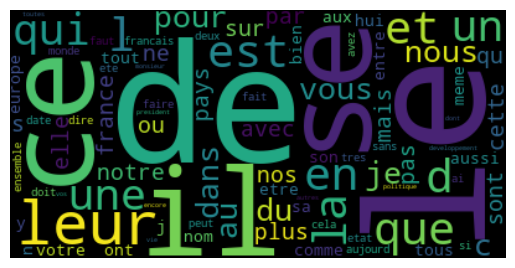

In [13]:
from collections import Counter

wc = Counter()
for text in alltxts:
    wc.update(text.split(" "))
    
freq_w = [w for w,f in wc.most_common(100)]
freq_w_str = ' '.join(freq_w)

from wordcloud import WordCloud

wordcloud = WordCloud().generate(freq_w_str)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

print(freq_w)

Nous créons une fonction de classification pour comparer l'efficacité de plusieurs prétraitements à effectuer sur notre dataset.

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

def classif_report(X, classes):

    # Définition des modèles
    
    # Naïve Bayes
    nb_clf = MultinomialNB()

    # Logistic Regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)

    # Linear SVM
    svm_clf = LinearSVC(random_state=0, tol=1e-5, dual='auto', max_iter=5000)

    # modèle de validation croisée
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cross_val_results_nb = []
    cross_val_results_lr = []
    cross_val_results_svm = []

    # entraînement et évaluation des modèles 
    for train_idx, test_idx in cv.split(X, classes):
        X_train, X_test= X[train_idx], X[test_idx]
        Y_train, Y_test = classes[train_idx], classes[test_idx]

        # Entraîner les modèles
        nb_clf.fit(X_train, Y_train)
        nb_pred = nb_clf.predict(X_test)

        lr_clf.fit(X_train, Y_train)
        lr_pred = lr_clf.predict(X_test)

        svm_clf.fit(X_train, Y_train)
        svm_pred = svm_clf.predict(X_test)
        
        # Calculer l'exactitude et stocker les résultats
        nb_accuracy = accuracy_score(Y_test, nb_pred)
        cross_val_results_nb.append(nb_accuracy)

        lr_accuracy = accuracy_score(Y_test, lr_pred)
        cross_val_results_lr.append(lr_accuracy)

        svm_accuracy = accuracy_score(Y_test, svm_pred)
        cross_val_results_svm.append(svm_accuracy)
    
    nb_accuracy, lr_accuracy, svm_accuracy = np.mean(cross_val_results_nb), np.mean(cross_val_results_lr), np.mean(cross_val_results_svm)

    # Affichage des évaluations des différents modèles
    print("Cross-Validation Accuracies:")
    print("Naive Bayes:", nb_accuracy)
    print("Logistic Regression:", lr_accuracy)
    print("Linear SVM:", svm_accuracy)

    return nb_accuracy, lr_accuracy, svm_accuracy


In [15]:
classes = np.array(alllabs)

import pandas as pd
score = pd.DataFrame([list(classif_report(X, classes))], index=['No preprocessing'], columns=['Naive Bayes', 'Logistic Regression', 'SVM'])
score

/Users/paulrousseau/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/paulrousseau/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Cross-Validation Accuracies:
Naive Bayes: 0.8835456192574036
Logistic Regression: 0.9016425817506588
Linear SVM: 0.8868027640899842


,Naive Bayes,Logistic Regression,SVM
No preprocessing,0.883546,0.901643,0.886803


Nous obtenons une précision de classification élevée avec un modèle sac de mots sans prétraitement. Testons de retirer les stop words du modèle (les mots très fréquents de la langue liés à la syntaxe).

In [17]:
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
print(stopwords.words('french'))

vectorizer = CountVectorizer(stop_words=stopwords.words('french'))
X = vectorizer.fit_transform(alltxts)

score.loc['Stop words removal'] = list(classif_report(X, classes))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulrousseau/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

Nous perdons en précision avec cette technique. Testons d'effectuer un processus de stemming, c'est à dire de retirer la fin de certains mots pour rapprocher les mots similaires.

In [18]:
from nltk.stem.snowball import FrenchStemmer

def vect_preprocess(text):
    """
    Transforms text to remove unwanted bits.
    """
    fs = FrenchStemmer()
    french_stem = [fs.stem(word) for word in text.split(" ")]
    new_text = ' '.join(french_stem)
    return new_text

vectorizer = CountVectorizer(preprocessor=vect_preprocess)
X = vectorizer.fit_transform(alltxts)

score.loc['Stemming'] = list(classif_report(X, classes))


Cross-Validation Accuracies:
Naive Bayes: 0.8817516751094061
Logistic Regression: 0.8998137079353448
Linear SVM: 0.8913661179921339


Nous observons toujours une perte de précision. Testons alors de considérer aussi les paires de mots dans la phrase. 

In [42]:
vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word') #Attention, cela peut prendre du temps
X = vectorizer.fit_transform(alltxts)

score.loc['Bigrams'] = list(classif_report(X, classes))

/home/mverlynde/miniconda3/envs/projvguig/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mverlynde/miniconda3/envs/projvguig/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Cross-Validation Accuracies:
Naive Bayes: 0.8869246303575199
Logistic Regression: 0.9091321216221072
Linear SVM: 0.900127225476926


Essayons ensuite une approche basée sur la présence/absence du mot dans la phrase.

In [45]:
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(alltxts)

score.loc['Binary'] = list(classif_report(X, classes))

/home/mverlynde/miniconda3/envs/projvguig/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross-Validation Accuracies:
Naive Bayes: 0.886210543389702
Logistic Regression: 0.9016948283538371
Linear SVM: 0.8864369574720113


Enfin, testons une approche TF-IDF pour prendre en compte le poids des mots dans les documents, et des documents pour chaque mot.

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(alltxts)

score.loc['TF-IDF'] = list(classif_report(X, classes))

Cross-Validation Accuracies:
Naive Bayes: 0.8697856147867944
Logistic Regression: 0.8939613784699609
Linear SVM: 0.9017818969243979


Comparons les scores après les différents prétraitements.

In [52]:
score

,Naive Bayes,Logistic Regression,SVM
No preprocessing,0.883354,0.900406,0.885514
Stop words removal,0.883650,0.898194,0.884103
Stemming,0.881752,0.899814,0.891349
Bigrams,0.886925,0.909132,0.900127
Binary,0.886211,0.901695,0.886437
TF-IDF,0.869786,0.893961,0.901782


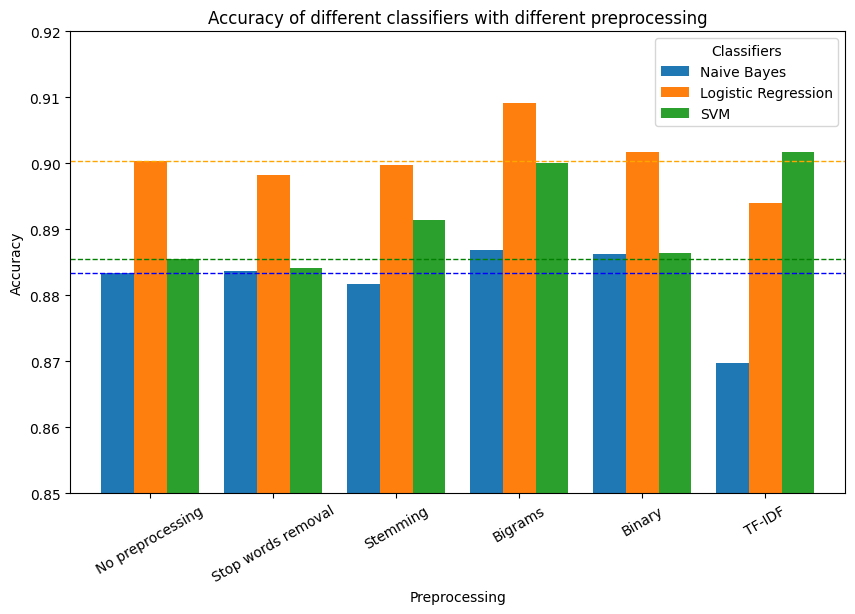

In [53]:
# Plotting
ax = score.plot(kind='bar', width=0.8, figsize=(10, 6))

ax.set_xlabel('Preprocessing')
ax.set_ylabel('Accuracy')
ax.legend(title='Classifiers')
ax.set_ylim(0.85, 0.92)
ax.axhline(score.iloc[0]['Naive Bayes'], color='blue', linestyle='--', linewidth=1)
ax.axhline(score.iloc[0]['Logistic Regression'], color='orange', linestyle='--', linewidth=1)
ax.axhline(score.iloc[0]['SVM'], color='green', linestyle='--', linewidth=1)
ax.set_title('Accuracy of different classifiers with different preprocessing')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
plt.show()

Nous observons que seuls le stemming, l'analyse des bigrammes, la binarisation et l'approche TF-IDF augmentent les performances. Cumulons alors ces approches.

/home/mverlynde/miniconda3/envs/projvguig/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mverlynde/miniconda3/envs/projvguig/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Cross-Validation Accuracies:
Naive Bayes: 0.8689495417163029
Logistic Regression: 0.8891540827004736
Linear SVM: 0.9088012158503419


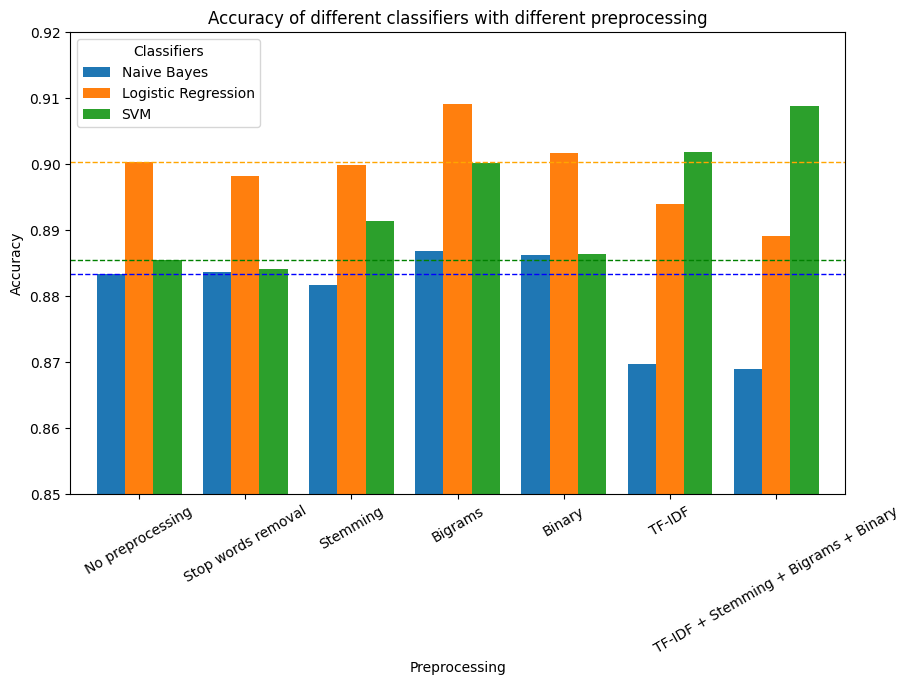

In [54]:
vectorizer = TfidfVectorizer(preprocessor=vect_preprocess, ngram_range=(1,2), analyzer='word', binary=True)
X = vectorizer.fit_transform(alltxts)

score.loc['TF-IDF + Stemming + Bigrams + Binary'] = list(classif_report(X, classes))

# Plotting
ax = score.plot(kind='bar', width=0.8, figsize=(10, 6))

ax.set_xlabel('Preprocessing')
ax.set_ylabel('Accuracy')
ax.legend(title='Classifiers')
ax.set_ylim(0.85, 0.92)
ax.axhline(score.iloc[0]['Naive Bayes'], color='blue', linestyle='--', linewidth=1)
ax.axhline(score.iloc[0]['Logistic Regression'], color='orange', linestyle='--', linewidth=1)
ax.axhline(score.iloc[0]['SVM'], color='green', linestyle='--', linewidth=1)
ax.set_title('Accuracy of different classifiers with different preprocessing')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
plt.show()

Nous obtenons alors une précision de classification significativement augmentée pour le classifieur SVM, avec environ 90,9%.

## Approche Representation Learning

Pour cette approche, nous utilisons le modèle de NLP word2vec. Ce modèle réalise des embeddings des mots du corpus, c'est-à-dire des représentations vectorielles de ces mots, afin de rendre compte numériquement des propriétés sémantiques les reliant.

In [19]:
# Import des librairies utiles à ce modèle
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

text = [t.split() for t in alltxts]

# Définition et entraînement du modèle sur le corpus (en laissant les paramètres par défaut)
w2v = gensim.models.word2vec.Word2Vec(sentences=text,
                                vector_size=100, window=5,               
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=1, hs=0, negative=5,      
                                cbow_mean=1, epochs=5)

2024-01-14 23:53:51,846 : INFO : collecting all words and their counts
2024-01-14 23:53:51,847 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-01-14 23:53:51,898 : INFO : PROGRESS: at sentence #10000, processed 235057 words, keeping 12871 word types
2024-01-14 23:53:51,946 : INFO : PROGRESS: at sentence #20000, processed 468912 words, keeping 17871 word types
2024-01-14 23:53:51,999 : INFO : PROGRESS: at sentence #30000, processed 694062 words, keeping 21091 word types
2024-01-14 23:53:52,054 : INFO : PROGRESS: at sentence #40000, processed 916650 words, keeping 23492 word types
2024-01-14 23:53:52,110 : INFO : PROGRESS: at sentence #50000, processed 1151623 words, keeping 25703 word types
2024-01-14 23:53:52,153 : INFO : collected 27079 word types from a corpus of 1321441 raw words and 57413 sentences
2024-01-14 23:53:52,154 : INFO : Creating a fresh vocabulary
2024-01-14 23:53:52,201 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 reta

In [20]:
# Sauvegarde du modèle
w2v.save("W2v-presidents.dat")

# You will be able to reload them:
w2v = gensim.models.Word2Vec.load("W2v-presidents.dat")
# and you can continue the learning process if needed

2024-01-14 23:54:35,398 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'W2v-presidents.dat', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-01-14T23:54:35.398712', 'gensim': '4.3.2', 'python': '3.11.4 (main, Jul  5 2023, 08:41:25) [Clang 14.0.6 ]', 'platform': 'macOS-10.13.6-x86_64-i386-64bit', 'event': 'saving'}
2024-01-14 23:54:35,403 : INFO : not storing attribute cum_table
2024-01-14 23:54:35,439 : INFO : saved W2v-presidents.dat
2024-01-14 23:54:35,442 : INFO : loading Word2Vec object from W2v-presidents.dat
2024-01-14 23:54:35,456 : INFO : loading wv recursively from W2v-presidents.dat.wv.* with mmap=None
2024-01-14 23:54:35,456 : INFO : setting ignored attribute cum_table to None
2024-01-14 23:54:35,554 : INFO : Word2Vec lifecycle event {'fname': 'W2v-presidents.dat', 'datetime': '2024-01-14T23:54:35.554465', 'gensim': '4.3.2', 'python': '3.11.4 (main, Jul  5 2023, 08:41:25) [Clang 14.0.6 ]', 'platform': 'macOS-10.13.6-x86_64-i386-64

Maintenant que le modèle est entraîné, on peut obtenir une représentation vectorielle pour chaque citation, ce qui va être nécessaire pour la classification qui va suivre.  
  Il existe différentes façons de représenter un texte à partir des représentations des mots qui la composent. Les méthodes les plus courantes sont la moyenne ou la somme des mots selon les dimensions. De cette façon, on obtient un unique vecteur de dimension fixe (le nombre de dimensions de l'embedding du modèle, 100 ici) pour chaque citation, à partir des vecteurs des mots de la citation.

In [21]:
import numpy as np
# We first need to vectorize text:
# First we propose to a sum of them


# Fonction renvoyant la représentation vectorielle d'une citation,
# à partir de la moyenne (argument mean=True) ou de la somme (mean=False) des représentations
#des mots qui la composent

def vectorize(text,mean=True):
    
    text = text.split(' ')
    word_vec = []    
    for word in text:
        if word in w2v.wv.key_to_index :
            word_vec.append( w2v.wv[word] )
        else :
            pass
    if mean:
        vec = np.mean(word_vec, axis=0)
    else:
        vec = np.sum(word_vec, axis=0)
            
    return vec
    


classes = [lab for lab in alllabs]             # liste contenant les étiquettes des citations
X = [vectorize(text) for text in alltxts]      # liste contenant les embeddings des citations

/Users/paulrousseau/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrousseau/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Par curiosité, on peut afficher la représentation vectorielle de la première citation du corpus.

In [22]:
print(X[0])

[ 0.06781609  0.13071235  0.05477865 -0.12422696 -0.08037201 -0.30102712
  0.10323623  0.44328055 -0.2191863  -0.28245127  0.11815506 -0.21793793
  0.09625411  0.01170595  0.01326833 -0.05179858  0.2930828  -0.16419648
  0.11688615 -0.26717103  0.12417492 -0.15961182  0.1776607  -0.1037797
 -0.15920366  0.02152201 -0.32276574  0.12656038  0.02145323  0.11459792
  0.13830343 -0.15335612  0.27628484 -0.12505563 -0.19435382  0.153341
 -0.04765799 -0.10026032 -0.04042966 -0.29686648 -0.18007958 -0.01461342
 -0.04937104  0.1892668   0.11900496 -0.17894389 -0.1931327  -0.13053304
  0.29689214  0.01222308  0.17540509 -0.15061112  0.04378653 -0.05134332
  0.04896177  0.12261578  0.20952155  0.25992283  0.08229188  0.07645785
 -0.12528805 -0.01040033  0.06747065  0.08263917 -0.3488753   0.25474063
  0.08830512  0.24054654 -0.34400177  0.21752341 -0.07484313  0.11703342
  0.34427226 -0.07693423  0.0858142   0.04791941  0.08812869  0.17698835
 -0.19724488 -0.09503641 -0.15618199  0.01159416 -0.08

Dans la partie suivante, lorsqu'on fournissait directement ces données à notre modèle de classification, il y avait un problème de dimension sur X. Le code suivant nous a permis de comprendre que certaines citations "vides" ne pouvaient être vectorisées correctement. Nous avons cherché où étaient ces données, afin de les suprrimer de notre X pour pouvoir faire tourner notre modèle.

In [23]:
X = [np.array(vec) if isinstance(vec, (list, np.ndarray)) else np.array([vec]) for vec in X]

# Vérifier les types de données
incorrect_types = [type(vec) for vec in X if not isinstance(vec, np.ndarray)]
print("Types incorrects :", set(incorrect_types))

# Vérifier les dimensions
incorrect_dimensions = [vec.shape for vec in X if vec.ndim != 1 or len(vec) != 100]
print("Dimensions incorrectes :", set(incorrect_dimensions))

# Trouver l'indice des vecteurs de mauvaise dimension
incorrect_indices = [i for i, vec in enumerate(X) if vec.ndim != 1 or len(vec) != 100]

# Enlever les vecteurs de mauvaise dimension
X = [vec for i, vec in enumerate(X) if i not in incorrect_indices]
classes = [lab for i, lab in enumerate(classes) if i not in incorrect_indices]

print(len(X))

Types incorrects : set()
Dimensions incorrectes : {(1,)}
57367


In [26]:
nb_erreurs = len([vec for i, vec in enumerate(alltxts) if i in incorrect_indices])
print('Nous avons enlevé de X', nb_erreurs, 'citations dont l embedding a échoué')

Nous avons enlevé de X 46 citations dont l embedding a échoué


Maintenant que nos données d'embeddings sont toutes au bon format, nous pouvons leur appliquer un classifieur.

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [84]:
# transformation des données en vecteur pour le modèle de classification
X = np.array([np.array(vec) for vec in X])
classes_1 = np.array(classes_1).reshape(-1,1)


# modèle SVM
model = SVC(kernel='linear')

# modèle de validation croisée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Liste pour stocker les résultats de la validation croisée
cross_val_results = []

# Boucle de validation croisée
for train_idx, test_idx in cv.split(X, classes):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = classes[train_idx], classes[test_idx]

    
    # entraînement du modèle sur l'ensemble d'entraînement
    model.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
    predictions = model.predict(X_test)

    # évaluation du modèle
    accuracy = accuracy_score(y_test, predictions)
    cross_val_results.append(accuracy)


mean_accuracy = np.mean(cross_val_results)
print("Cross-Validation Accuracy:", mean_accuracy)


/home/mverlynde/miniconda3/envs/projvguig/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mverlynde/miniconda3/envs/projvguig/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mverlynde/miniconda3/envs/projvguig/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mverlynde/miniconda3/envs/projvguig/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversio

Cross-Validation Accuracy: 0.8688967531609139


Ce modèle fait preuve d'une bonne efficacité dans ses prédictions, mais il reste légèrement moins performant que les modèles de l'approche sac de mots (87% de précision ici, contre 91% pour le meilleur modèle bag of words avec les bons pré-traitements).  
En revanche, sa mise en oeuvre est plus rapide. Le choix de l'approche dépend donc du critère à optimiser (temps ou précision), sans grande différence néanmoins dans notre cas présent d'études.